In [357]:
import skimage
import skimage.io as io
from skimage.color import rgb2gray
import scipy
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import csv
import copy
import os
import pylab as pl
from matplotlib import collections as mc

In [358]:
# smoothing
# contrast enhancement filters
# segmentation?

In [359]:
from skimage.filters import threshold_otsu, threshold_local, threshold_minimum, threshold_mean, threshold_triangle, try_all_threshold
from skimage.util import invert

In [360]:
# os.chdir("/home/user/Desktop")

In [413]:
# section = io.imread("small/1_11.jpg")   
# section = io.imread("large/3_17.jpg") 
section = io.imread("large/1_13.jpg")
# section = io.imread("large/2_2.jpg")  
# section = io.imread("large/2_7.jpg")  
# section = io.imread("large/3_5.jpg") 
# section = io.imread("garima/1_0.jpg")

# section[51:70, 30:60] = section[1:20, 2:32]
# io.imshow(section)

gray_section = rgb2gray(section) 

## Filters

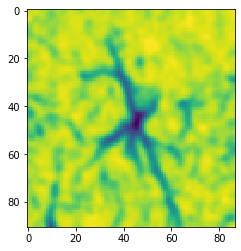

In [414]:
from skimage import filters
from scipy import ndimage as ndi
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)

        
mean_kernel = np.full((3, 3), 1/9)

bright_square = gray_section
smooth_mean = ndi.correlate(bright_square, mean_kernel)
sigma = 1
smooth = filters.gaussian(bright_square, sigma)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(smooth)
plt.show()

# imshow_all(bright_square, smooth_mean, smooth,
#            titles=['original', 'result of mean filter', 'result of gaussian filter'])

## Entropy and Complexity

In [415]:
import shearlexity
from FFST import shearletTransformSpect

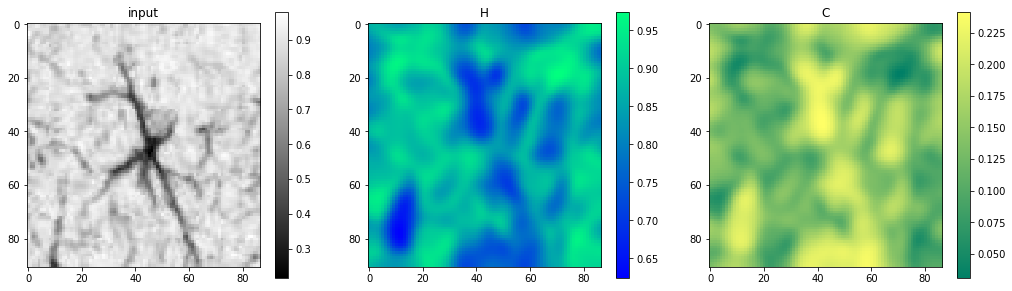

In [416]:
h,c = shearlexity.map_cecp(gray_section,3)
# f = gcf()
# ax = f.axes[0]
# ax.contour(Tr_profile,[1.],colors=['y'],)
# plt.show()

## Soma Detection

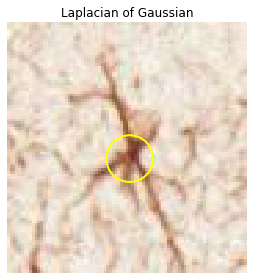

In [417]:
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh

image_gray = gray_section
image_gray = invert(image_gray)

blobs_log = blob_log(image_gray, min_sigma=6, max_sigma=20, num_sigma=10, threshold=0.1, overlap=0.3)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Laplacian of Gaussian')
ax.imshow(section, interpolation='nearest')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [418]:
# find the blobs too close to border so as to eliminate them

def eliminate_border_blobs(blobs_log):
    blobs_dict = defaultdict()
    for i, blob in enumerate(blobs_log):
        blobs_dict[i] = blob
        y, x, r = blob
        image_border_x, image_border_y = image_gray.shape[0]/4, image_gray.shape[1]/4
        if x < image_border_x or x > 3*image_border_x or y < image_border_y or y > 3*image_border_y:
            blobs_dict.pop(i)
            
    return blobs_dict

In [419]:
# find the blob with highest intensity value

def centre_of_mass(blobs_dict):
    ixs = np.indices(image_gray.shape)
    xms = []
    yms = []
    ms = []
    for i, blob in blobs_dict.items():
        y, x, r = blob
        # Define an array of shape `[2, 1, 1]`, containing the center of the blob
        blob_center = np.array([y, x])[:, np.newaxis, np.newaxis]
        # Using the formula for a circle, `x**2 + y**2 < r**2`, generate a mask for this blob.
        mask = ((ixs - blob_center)**2).sum(axis=0) < r**2
        # Calculate the average intensity of pixels under the mask
        blob_avg_est = image_gray[mask].mean()
        yms.append(blob_avg_est*y)
        xms.append(blob_avg_est*x)
        ms.append(blob_avg_est)
        # print(f'Blob {i}: Centre {(x, y)}, average value: {blob_avg_est:.2f}')
    return (sum(yms)/sum(ms), sum(xms)/sum(ms))

In [420]:
remaining_blobs = eliminate_border_blobs(blobs_log)

if len(remaining_blobs)==1:
    soma = list(remaining_blobs.values())[0][:2]
if len(remaining_blobs)>1:
    soma = centre_of_mass(remaining_blobs)
    
soma

array([49., 44.])

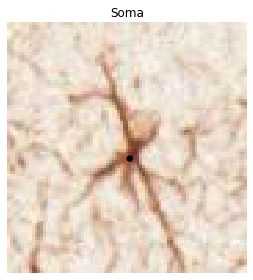

In [421]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Soma')
ax.imshow(section, interpolation='nearest')

y, x = soma[0], soma[1]
c = plt.Circle((x, y), 1, color='black')
ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Thresholding

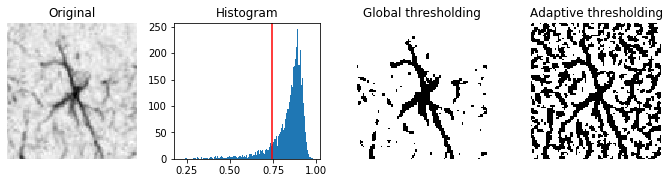

In [422]:
binary_global = gray_section > threshold_otsu(gray_section)

block_size = 21
binary_adaptive = gray_section > threshold_local(gray_section, block_size, offset=0)

fig, axes = plt.subplots(ncols=4, figsize=(12, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3, sharex=ax[0], sharey=ax[0])
ax[3] = plt.subplot(1, 4, 4, sharex=ax[0], sharey=ax[0])

ax[0].imshow(gray_section, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(gray_section.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(threshold_otsu(gray_section), color='r')

ax[2].imshow(binary_global, cmap=plt.cm.gray)
ax[2].set_title('Global thresholding')
ax[2].axis('off')

ax[3].imshow(binary_adaptive, cmap=plt.cm.gray)
ax[3].set_title('Adaptive thresholding')
ax[3].axis('off')

plt.show()

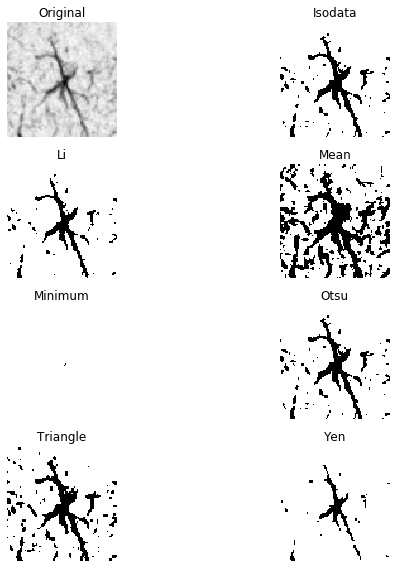

In [423]:
fig, ax = try_all_threshold(gray_section, figsize=(10, 8), verbose=False)
plt.show()

## Surface Area

## Skeletonization

In [424]:
from skimage.morphology import skeletonize

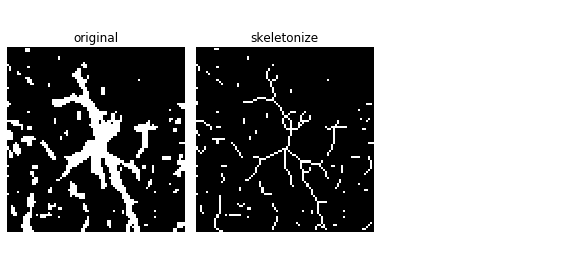

In [425]:
# Invert the astrocyte image
binary_global = gray_section > threshold_triangle(gray_section)
data = invert(binary_global)

# perform skeletonization
skeleton = skeletonize(data)
# skeleton3d = skeletonize_3d(data)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('skeletonize')
ax[1].axis('off')

# ax[2].imshow(skeleton3d, cmap=plt.cm.gray, interpolation='nearest')
# ax[2].set_title('skeletonize_3d')
ax[2].axis('off')

fig.tight_layout()
plt.show()

In [426]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

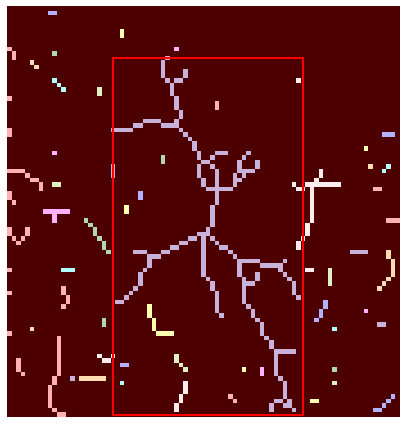

In [427]:
bw = closing(skeleton, square(1))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=skeleton)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

no_of_regions = 0
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        no_of_regions+=1
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
#         ax.imshow(label_image[minr:maxr, minc:maxc])

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [428]:
# if no_of_regions>1:
#     increase the region area size iteratively till only one region is detected

In [429]:
from skimage import morphology

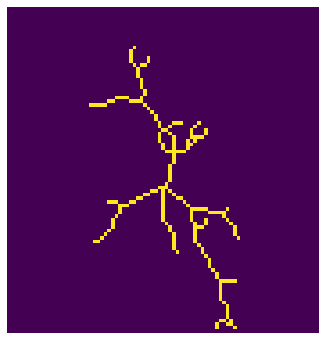

In [430]:
boxed_astrocyte = label_image
final = morphology.remove_small_objects(boxed_astrocyte, 50)
final[final > final.mean()] = 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(final)
ax.set_axis_off()
plt.show()

In [431]:
def distance(P1, P2):
    """
    computing the distance between 2 points
    """
    return ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5

In [432]:
cell_pixel_coordinates = [(i, j) for (i, j), val in np.ndenumerate(final) if val!=0]

In [433]:
soma_on_skeleton = min(cell_pixel_coordinates, key=lambda x: distance(soma, x))
soma_on_skeleton

(49, 44)

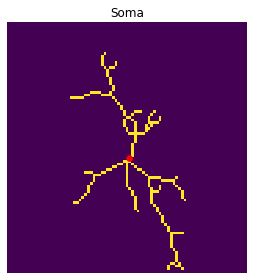

In [434]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Soma')
ax.imshow(final, interpolation='nearest')

y, x = soma_on_skeleton
c = plt.Circle((x, y), 1, color='red')
ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [435]:
def plot(cell_pixel_coordinates, color):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title('path')
    ax.imshow(final, interpolation='nearest')

    for i in cell_pixel_coordinates:
        c = plt.Circle((i[1], i[0]), 0.5, color=color)
        ax.add_patch(c)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

## Total length

## Skeleton Analysis

In [436]:
import skan
from skan.pre import threshold
from skan import draw
from skan import skeleton_to_csgraph
from skan import Skeleton, summarize

In [437]:
spacing = 1
spacing_nm = spacing * 1e9  # nm per pixel
# smooth_radius = 5 / spacing_nm  # float OK
# threshold_radius = int(np.ceil(50 / spacing_nm))
# binary0 = threshold(gray_section, sigma=smooth_radius, radius=threshold_radius)
# fig, ax = plt.subplots()
# ax.imshow(binary0);

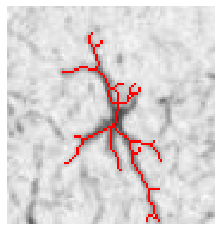

In [438]:
# skeleton0 = skeletonize(binary0)
fig, ax = plt.subplots()
draw.overlay_skeleton_2d(gray_section, final, dilate=0, axes=ax);

In [439]:
coordinates = skan.csr.Skeleton(final).coordinates

In [440]:
near = []
for i in range(skan.csr.Skeleton(final).n_paths):
    path_coords = skan.csr.Skeleton(final).path_coordinates(i)
    nearest = min(path_coords, key=lambda x: distance(soma_on_skeleton, x))
    near.append(nearest)

soma_on_path = min(near, key=lambda x: distance(soma_on_skeleton, x))
soma_node = [i for i,j in enumerate(skan.csr.Skeleton(final).coordinates) if all(soma_on_path==j)]
soma_node

[49]

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


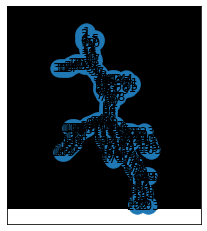

In [441]:
pixel_graph, coordinates, degrees = skeleton_to_csgraph(final)
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(pixel_graph, coordinates, image=final, axis=ax)

In [442]:
branch_data = summarize(Skeleton(final, spacing=spacing_nm))
branch_data.head()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,11,7.242641e+09,1,1.0,0.0,11.000000,35.000000,17.000000,36.000000,1.100000e+10,3.500000e+10,1.700000e+10,3.600000e+10,6.082763e+09
1,1,5,11,4.828427e+09,1,1.0,0.0,14.000000,39.000000,17.000000,36.000000,1.400000e+10,3.900000e+10,1.700000e+10,3.600000e+10,4.242641e+09
2,1,11,23,9.962802e+09,2,1.0,0.0,17.000000,36.000000,25.666667,36.666667,1.700000e+10,3.600000e+10,2.566667e+10,3.666667e+10,8.692270e+09
3,1,23,30,1.494231e+10,1,1.0,0.0,25.666667,36.666667,27.000000,23.000000,2.566667e+10,3.666667e+10,2.700000e+10,2.300000e+10,1.373155e+10
4,1,23,28,1.134525e+10,2,1.0,0.0,25.666667,36.666667,34.000000,43.500000,2.566667e+10,3.666667e+10,3.400000e+10,4.350000e+10,1.077678e+10


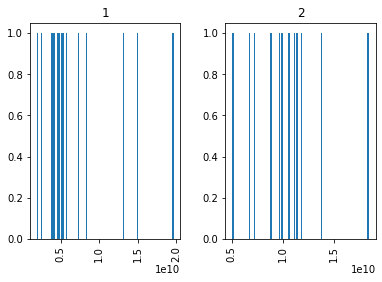

In [443]:
branch_data.hist(column='branch-distance', by='branch-type', bins=100);

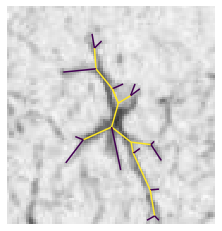

In [444]:
draw.overlay_euclidean_skeleton_2d(gray_section, branch_data, skeleton_color_source='branch-type');

In [458]:
branch_statistics = skan.csr.branch_statistics(pixel_graph)
branch_statistics

array([[  1.        ,  11.        ,   7.24264069,   1.        ],
       [  5.        ,  11.        ,   4.82842712,   1.        ],
       [ 11.        ,  23.        ,   9.96280187,   2.        ],
       [ 23.        ,  30.        ,  14.94231386,   1.        ],
       [ 23.        ,  28.        ,  11.34524797,   2.        ],
       [ 43.        ,  28.        ,   5.2169892 ,   1.        ],
       [ 44.        ,  29.        ,   5.71945198,   1.        ],
       [ 51.        ,  29.        ,   5.43676256,   1.        ],
       [ 28.        ,  48.        ,   9.63120276,   2.        ],
       [ 28.        ,  48.        ,   7.2169892 ,   2.        ],
       [ 48.        ,  29.        ,   6.75976096,   2.        ],
       [ 48.        ,  49.        ,  11.10493837,   2.        ],
       [ 49.        ,  54.        ,  13.77313662,   2.        ],
       [ 49.        ,  58.        ,  10.60159836,   2.        ],
       [ 49.        , 172.        ,  19.66682937,   1.        ],
       [104.        ,  54

In [459]:
# loop elimination
# make sure to use updated branch list only, with loops eliminated

loop_indexes = []
boundary_points = (branch_statistics[0][0], branch_statistics[0][1])
for branch_no, branch in enumerate(branch_statistics[1:]):
    if boundary_points == (branch[0], branch[1]):
        loop_indexes.append(branch_no+1)
    boundary_points = (branch[0], branch[1])

branch_statistics = np.delete(branch_statistics, loop_indexes, axis=0)
branch_statistics

array([[  1.        ,  11.        ,   7.24264069,   1.        ],
       [  5.        ,  11.        ,   4.82842712,   1.        ],
       [ 11.        ,  23.        ,   9.96280187,   2.        ],
       [ 23.        ,  30.        ,  14.94231386,   1.        ],
       [ 23.        ,  28.        ,  11.34524797,   2.        ],
       [ 43.        ,  28.        ,   5.2169892 ,   1.        ],
       [ 44.        ,  29.        ,   5.71945198,   1.        ],
       [ 51.        ,  29.        ,   5.43676256,   1.        ],
       [ 28.        ,  48.        ,   9.63120276,   2.        ],
       [ 48.        ,  29.        ,   6.75976096,   2.        ],
       [ 48.        ,  49.        ,  11.10493837,   2.        ],
       [ 49.        ,  54.        ,  13.77313662,   2.        ],
       [ 49.        ,  58.        ,  10.60159836,   2.        ],
       [ 49.        , 172.        ,  19.66682937,   1.        ],
       [104.        ,  54.        ,   3.88561808,   1.        ],
       [ 58.        ,  59

In [460]:
degrees

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [448]:
skan.csr.Skeleton(final).n_paths

27

In [449]:
paths_list = skan.csr.Skeleton(final).paths_list()
del paths_list[6]
paths_list

[[1, 2, 3, 4, 6, 8, 11],
 [5, 7, 10, 9, 11],
 [11, 12, 13, 14, 15, 16, 17, 18, 23],
 [23, 27, 26, 22, 21, 20, 19, 25, 24, 34, 33, 32, 31, 30],
 [23, 35, 36, 37, 38, 39, 40, 45, 28],
 [28, 46, 41, 42, 43],
 [28, 53, 57, 63, 67, 48],
 [29, 50, 47, 44],
 [29, 61, 55, 51],
 [29, 78, 77, 48],
 [48, 80, 81, 82, 83, 84, 85, 86, 49],
 [49, 92, 91, 96, 95, 100, 99, 108, 107, 113, 54],
 [49, 94, 98, 102, 103, 110, 115, 58],
 [49,
  97,
  101,
  109,
  114,
  117,
  125,
  133,
  137,
  142,
  147,
  153,
  157,
  161,
  166,
  168,
  170,
  172],
 [54, 106, 105, 104],
 [54, 124, 132, 136, 141, 146, 152, 156, 160, 165, 164],
 [58, 120, 121, 122, 127, 128, 129, 59],
 [58, 134, 138, 60],
 [59, 123],
 [59, 140, 145, 151, 155, 159, 163],
 [60, 150, 144, 139],
 [60, 158, 162, 167, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 64],
 [64, 183, 184, 185],
 [64, 187, 188, 189, 190, 191, 192, 193, 194, 65],
 [65, 196, 199, 202],
 [65, 203]]

In [450]:
soma_branches=[]
branches = []
for i in paths_list:
    if soma_node in i:
        soma_branches.append(i)
soma_branches

[[48, 80, 81, 82, 83, 84, 85, 86, 49],
 [49, 92, 91, 96, 95, 100, 99, 108, 107, 113, 54],
 [49, 94, 98, 102, 103, 110, 115, 58],
 [49,
  97,
  101,
  109,
  114,
  117,
  125,
  133,
  137,
  142,
  147,
  153,
  157,
  161,
  166,
  168,
  170,
  172]]

In [411]:
def branch_structure(junctions, branch_statistics):
    next_set_junctions = []
    next_set_branches = []
    for junction in junctions:
        branches_travelled = []
#         print(junction)
        for branch_no, branch in enumerate(branch_statistics):
#             print(branch_no, branch)
            if branch[0]==junction:
                if branch[3]==2:
                    next_set_junctions.append(branch[1])
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
                if branch[3]==1:
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
#                             print(path)
            elif branch[1]==junction:
                if branch[3]==2:
                    next_set_junctions.append(branch[0])
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
#                             print(path)
                if branch[3]==1:
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
#                             print(path)
        branch_statistics = np.delete(branch_statistics, branches_travelled, axis=0)
            
    return next_set_junctions, next_set_branches, branch_statistics



if len(soma_branches)>2:
    junctions = soma_node
    branch_array = []
#     junctions_travelled = []
    while True:
        junctions, branches, branch_statistics = branch_structure(junctions, branch_statistics)
        branch_array.append(branches)
        if len(junctions)==0:
            break
#         junctions = list(set(junctions)-set(junctions_travelled))
#         junctions_travelled.extend(junctions)
        print(junctions, branches)
else:
    # collect first level/primary branches
    i,j = branch_structure(junctions)

In [461]:
# if terminal branches should remain same color

def branch_structure(junctions, branch_statistics):
    next_set_junctions = []
    next_set_branches = []
    terminal_branches=[]
    for junction in junctions:
        branches_travelled = []
#         print(junction)
        for branch_no, branch in enumerate(branch_statistics):
#             print(branch_no, branch)
            if branch[0]==junction:
                if branch[3]==2:
                    next_set_junctions.append(branch[1])
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
                if branch[3]==1:
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            terminal_branches.append(path)
                            branches_travelled.append(branch_no)
#                             print(path)
            elif branch[1]==junction:
                if branch[3]==2:
                    next_set_junctions.append(branch[0])
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            next_set_branches.append(path)
                            branches_travelled.append(branch_no)
#                             print(path)
                if branch[3]==1:
                    for path in paths_list:
                        if branch[0]==path[0] and branch[1]==path[-1] or branch[0]==path[-1] and branch[1]==path[0]:
                            terminal_branches.append(path)
                            branches_travelled.append(branch_no)
#                             print(path)
        branch_statistics = np.delete(branch_statistics, branches_travelled, axis=0)
            
    return next_set_junctions, next_set_branches, terminal_branches, branch_statistics



terminal_branches = []
branch_array = []
if len(soma_branches)>2:
    junctions = soma_node
#     junctions_travelled = []
    while True:
        junctions, branches, terminal_branch, branch_statistics = branch_structure(junctions, branch_statistics)
        branch_array.append(branches)
        terminal_branches.extend(terminal_branch)
        if len(junctions)==0:
            break
#         junctions = list(set(junctions)-set(junctions_travelled))
#         junctions_travelled.extend(junctions)
        print(junctions, branches)
    branch_array[-1].extend(terminal_branches)
else:
    # collect first level/primary branches
    i,j = branch_structure(junctions)

[48.0, 54.0, 58.0] [[48, 80, 81, 82, 83, 84, 85, 86, 49], [49, 92, 91, 96, 95, 100, 99, 108, 107, 113, 54], [49, 94, 98, 102, 103, 110, 115, 58]]
[28.0, 29.0, 59.0, 60.0] [[28, 53, 57, 63, 67, 48], [29, 78, 77, 48], [58, 120, 121, 122, 127, 128, 129, 59], [58, 134, 138, 60]]
[23.0, 64.0] [[23, 35, 36, 37, 38, 39, 40, 45, 28], [60, 158, 162, 167, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 64]]
[11.0, 65.0] [[11, 12, 13, 14, 15, 16, 17, 18, 23], [64, 187, 188, 189, 190, 191, 192, 193, 194, 65]]


In [462]:
branch_array

[[[48, 80, 81, 82, 83, 84, 85, 86, 49],
  [49, 92, 91, 96, 95, 100, 99, 108, 107, 113, 54],
  [49, 94, 98, 102, 103, 110, 115, 58]],
 [[28, 53, 57, 63, 67, 48],
  [29, 78, 77, 48],
  [58, 120, 121, 122, 127, 128, 129, 59],
  [58, 134, 138, 60]],
 [[23, 35, 36, 37, 38, 39, 40, 45, 28],
  [60, 158, 162, 167, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 64]],
 [[11, 12, 13, 14, 15, 16, 17, 18, 23],
  [64, 187, 188, 189, 190, 191, 192, 193, 194, 65]],
 [[49,
   97,
   101,
   109,
   114,
   117,
   125,
   133,
   137,
   142,
   147,
   153,
   157,
   161,
   166,
   168,
   170,
   172],
  [54, 106, 105, 104],
  [54, 124, 132, 136, 141, 146, 152, 156, 160, 165, 164],
  [28, 46, 41, 42, 43],
  [29, 50, 47, 44],
  [29, 61, 55, 51],
  [59, 123],
  [59, 140, 145, 151, 155, 159, 163],
  [60, 150, 144, 139],
  [23, 27, 26, 22, 21, 20, 19, 25, 24, 34, 33, 32, 31, 30],
  [64, 183, 184, 185],
  [1, 2, 3, 4, 6, 8, 11],
  [5, 7, 10, 9, 11],
  [65, 196, 199, 202],
  [65, 203]]]

In [463]:
skan.csr.Skeleton(final).path(0)

array([ 1,  2,  3,  4,  6,  8, 11], dtype=int32)

In [464]:
skan.csr.Skeleton(final).path_coordinates(11)

array([[40. , 46. ],
       [42. , 46. ],
       [43. , 46. ],
       [44. , 45. ],
       [45. , 45. ],
       [46. , 45. ],
       [47. , 45. ],
       [48. , 45. ],
       [50. , 43.2]])

In [465]:
# plot(skan.csr.Skeleton(final).path_coordinates(6))
# skan.csr.Skeleton(final).path(6)

In [466]:
color_branches=[]
two=[]
three=[]
four=[]
for branch in branch_array:
    sub_branch=[]
    for paths in branch:
        sub_branch.extend(paths)
    color_branches.append(sub_branch)

color_branches_coords=[]
for branch in color_branches:
    sub_branch=[]
    for node in branch:
        sub_branch.append(coordinates[node])
    color_branches_coords.append(sub_branch)

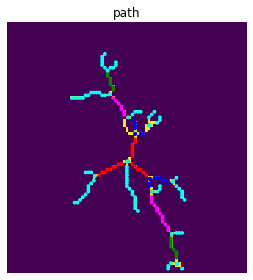

In [479]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('path')
ax.imshow(final, interpolation='nearest')

for i in color_branches_coords[0]:
    c = plt.Circle((i[1], i[0]), 0.5, color='red')
    ax.add_patch(c)
for i in color_branches_coords[1]:
    c = plt.Circle((i[1], i[0]), 0.5, color='blue')
    ax.add_patch(c)
for i in color_branches_coords[2]:
    c = plt.Circle((i[1], i[0]), 0.5, color='magenta')
    ax.add_patch(c)
for i in color_branches_coords[3]:
    c = plt.Circle((i[1], i[0]), 0.5, color='green')
    ax.add_patch(c)
for i in color_branches_coords[4]:
    c = plt.Circle((i[1], i[0]), 0.5, color='cyan')
    ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [107]:
def labelling(cell_pixel_coordinates):
    """
    label every pixel whether it's a slab, termination or junction
    """
    labels = defaultdict()
    for coord in cell_pixel_coordinates:
        indices = [v for i, v in enumerate(cell_pixel_coordinates) if distance(v, coord) < 2 and distance(v, coord) != 0]
        if len(indices)==2:
            labels[coord]="slab"
        if len(indices)<2:
            labels[coord]="termination"
        if len(indices)>2:
            labels[coord]="junction"
    return labels

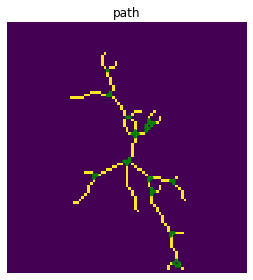

In [146]:
from matplotlib import collections as mc

labels = labelling(cell_pixel_coordinates)
forks = [key for key, value in labels.items() if value=="junction"]

plot(forks)

In [116]:
def get_filled_loop_coords(image):
    """
    fill the inside region of loops, and get the pixel coordinates of this region
    """
    filled = scipy.ndimage.binary_fill_holes(image)
    loops = scipy.logical_xor(image, filled)
    _, loop_count = scipy.ndimage.measurements.label(loops)
    labels = list(set(_[np.nonzero(_)]))
    loop_location = []
    for i in labels:
        loop_location.append(np.transpose(np.nonzero(_==i)))
    return loop_location

ValueError: setting an array element with a sequence.

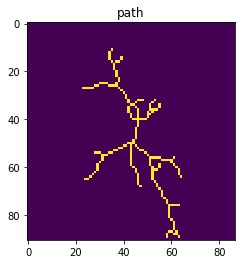

In [143]:
loop_coords = get_filled_loop_coords(final)
plot(loop_coords)

In [129]:
def get_loop_boundary_coords(inside_loop_coords, cell_pixel_coordinates):
    """
    get the loop pixel's coordinates
    """
    loop_boundary_coords = []
    # get the boundary of this filled loop section by finding the pixels touching it 
    for coords in inside_loop_coords:
        for cell_coord in cell_pixel_coordinates:
            if distance(cell_coord, coords) < 2:
                loop_boundary_coords.append(cell_coord)
    return list(set(loop_boundary_coords))

In [130]:
def get_slab_branches_in_loop(loop_image, cell_pixel_coordinates, labels):
    """
    get the (only) slab trails in recognised boundary coordinates
    """
    slab_trails = {}
    boundary_coords = get_loop_boundary_coords(loop_image, cell_pixel_coordinates)
    # store all the slab pixel coordinates
    slab_coords = [coord for coord in boundary_coords if labels[coord]=="slab"]
    for i, coord in enumerate(slab_coords):
        # traveling via nearest neighbour to store slab branches corresponding to their branch no.
        other_coords = [other_coord for other_coord in slab_coords if distance(coord, other_coord) < 2]
        slab_trails[i] = other_coords
        slab_coords.remove(coord)
    return slab_trails

In [131]:
def delete_loop_slabs(loop_image, actual_cell_gray_image, cell_pixel_coordinates, labels):
    """
    delete the lower intensity branch/trail to eliminate loop 
    """
    # delete slabs with lesser intensity
    slab_trails = get_slab_branches_in_loop(loop_image, cell_pixel_coordinates, labels)
    print(slab_trails)
    slab_intensities = {}
    # store the total intensities corresponding to each loop branch
    for trail_no, trail in slab_trails.items():
        intensity = sum([actual_cell_gray_image[coord] for coord in trail])
        slab_intensities[trail_no] = intensity
    # keep the loop branch with max intensity
    try:
        slab_to_keep = max(slab_intensities, key=slab_intensities.get)
        slab_trails.pop(slab_to_keep)
    except:
        pass
    # delete all other lower intensity branches
    for coords in slab_trails.values():
        for coord in coords:
            try:
                cell_pixel_coordinates.remove(coord)
            except:
                pass
            # also delete corresponding junctions of the branch
            corresponding_junctions = [pixel for pixel in cell_pixel_coordinates if labels[pixel]=="junction" and distance(coord, pixel)<2]
            for junction in corresponding_junctions:
                try:
                    cell_pixel_coordinates.remove(junction)
                except:
                    pass
            
#     # delete coords which changed from juntion to slab
#     new_labels = labelling(cell_pixel_coordinates)
#     junction_coords = [key for key, value in labels.items() if value=="junction"]
#     new_junction_coords = [key for key, value in new_labels.items() if value=="junction"]
#     coords_to_delete = list(set(new_junction_coords).difference(junction_coords))
#     for coord in coords_to_delete:
#         cell_pixel_coordinates.remove(coord)
    
    return cell_pixel_coordinates

0
{0: [(36, 42), (37, 42), (35, 42)], 1: [(35, 45), (36, 46)], 2: [(40, 44), (39, 43)], 3: [(36, 46), (37, 46)], 4: [(38, 43), (39, 43)]}
1
{}
2
{}


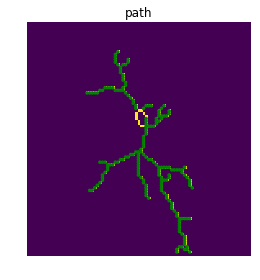

In [132]:
loop_coords = get_filled_loop_coords(final)
no_of_loops = len(loop_coords)
labels = labelling(cell_pixel_coordinates)
if no_of_loops!=0:
    for i,loop in enumerate(loop_coords):
        print(i)
        cell_pixel_coordinates = delete_loop_slabs(loop, gray_section, cell_pixel_coordinates, labels)

labels = labelling(cell_pixel_coordinates)

plot(cell_pixel_coordinates)

In [133]:
# handle the case where all loop boundary coordinates are junction
# for all loop_inside_pixels, select the ones touching max no. of junction pixel on both sides of loop
# get loop_inside_pixel touching atleat one of above selected point and whose sum distance from both ends is lowest



# start from soma, find no. of pixels directly connected, create arrays starting with those pixel
# for those pixel in array:
#     document slab tralis till next junction reached, and append to primary branch

# for junction in collected junctions:
#     travel via nearest neighbor till next junction is reached
#     save these junctions
#     append slab trail to secondary branch

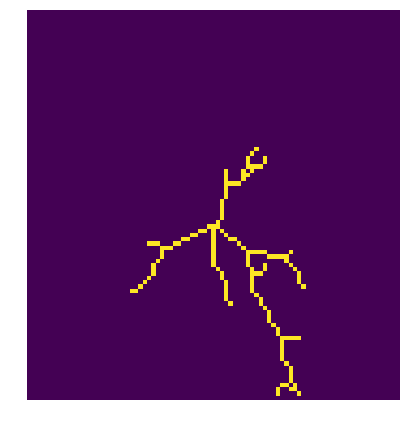

In [134]:
processed_final = np.zeros(final.shape, dtype=int)
for i in cell_pixel_coordinates:
    processed_final[i] = 1

bw = closing(processed_final, square(1))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)

processed_final = morphology.remove_small_objects(label_image, 50)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(processed_final)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [41]:
# def get_terminal_branches(terminations, cell_pixel_coordinates, labels):
    """
    delete outermost branches according to current terminations
    
    Return:
    sorted_branch_orders: list containing all the terminal branches
    """
    sorted_branch_orders = []
    pass_by = copy.deepcopy(cell_pixel_coordinates)
    for coord in terminations:
        continuous=True
        branches = []
        nearest = coord
        try:
            pass_by.remove(nearest)
        except:
            pass
        # travel till the junction (from where branch started) is reached
        while labels[nearest]!="junction":
#             print(nearest)
            branches.append((nearest, labels[nearest]))
            prev = nearest
            # travelling via nearest neighbour
            nearest = min(pass_by, key=lambda x: distance(nearest, x))
            if distance(nearest, prev)>2:
                try:
                    pass_by.remove(nearest)
                except:
                    pass
                continuous=False
                break
            try:
                pass_by.remove(nearest)
            except:
                pass
        if continuous==True:
            branches.append((nearest, labels[nearest]))
        sorted_branch_orders.append(branches)
    return sorted_branch_orders

IndentationError: unexpected indent (<ipython-input-41-a36af41c51d3>, line 2)

In [42]:
def branch_pruning(cell_pixel_coordinates, order, previous_labels):

    labels = labelling(cell_pixel_coordinates)
    terminations = [key for key, value in labels.items() if value=="termination"]
    if order>0:
        for i in cell_pixel_coordinates:
            if i in terminations:
                pass
            else:
                labels[i] = previous_labels[i]
        for j in terminations:
            for coord in cell_pixel_coordinates:
                if distance(j, coord) < 2 and distance(j, coord) != 0 and labels[coord]=="junction":
                    labels[coord]="slab"

    branch_order = get_terminal_branches(terminations, cell_pixel_coordinates, labels)
    for j in branch_order:
        if len(j)<2:
            branch_order.remove(j)
        for i in j:
            try:
                cell_pixel_coordinates.remove(i[0])
            except ValueError:
                pass

    plot(cell_pixel_coordinates)
    return branch_order, labels


tree = []
order=0
while cell_pixel_coordinates:
    if order==0:
        labels=None
        branch_order, labels = branch_pruning(cell_pixel_coordinates, order, labels)
    else:
        # check if only junction coords are remaining, then just stop the pruning
        if all(labels[coord]=="junction" for coord in cell_pixel_coordinates):
            break
        else:
            branch_order, labels = branch_pruning(cell_pixel_coordinates, order, labels)
#     print(labels)
    tree.append(branch_order)
    order+=1    

NameError: name 'get_terminal_branches' is not defined

In [ ]:
for i in tree:
    print(len(i))

In [ ]:
# len(tree[1])

In [ ]:
# len(tree[2])

In [ ]:
# try1 = []
# for coords in tree[2][0]:
#     try1.append(coords[0])
# plot(try1)

In [ ]:
# try2 = []
# for coords in tree[2][1]:
#     try2.append(coords[0]) 
# plot(try2)

In [ ]:
# try3 = []
# for coords in tree[2][2]:
#     try3.append(coords[0]) 
# plot(try3)

In [ ]:
# try4 = []
# for coords in tree[2][3]:
#     try4.append(coords[0]) 
# plot(try4)

In [ ]:
# try5 = []
# for coords in tree[2][4]:
#     try5.append(coords[0]) 
# plot(try5)

If more than two objects are still there then black out the small one i.e with less pixel sum value

In [ ]:
# cell_pixel_coordinates = [(i,j) for (i, j), val in np.ndenumerate(boxed_astrocyte) if val==0]

# def cell_neighbors(boxed_astrocyte, cell_pixel_coordinates, d):
#     """Return d-th neighbors of cell (i, j)"""
#     windows = []
#     for k in cell_pixel_coordinates:
#         window = boxed_astrocyte[i-d:i+d+1, j-d:j+d+1].flatten()
#     windows.append(window)
#     return windows

In [ ]:
# fork_windows = []
# end_point_windows = []
# for window in cell_neighbors():
#     if window[window.shape - 1, window.shape - 1] == 0:
#     # check if centre is black then only proceed
#         no_of_black_neighbors = 0
#     for (i, j), val in np.ndenumerate(window):
#         if val==0:
#             no_of_black_neighbors+=1
#     if no_of_black_neighbors == 2:
#         end_point_windows.append(window)
#     if no_of_black_neighbors >= 3:
#         fork_windows.append(window)

/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


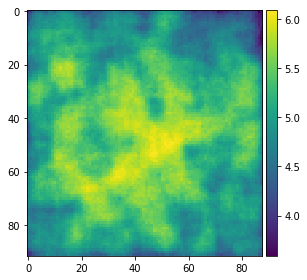

In [93]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

ent = entropy(gray_section, disk(5))
io.imshow(ent)
io.show()

In [69]:
def sholl(cell_image, soma):

    concentric_coordinates = defaultdict(list) # {100: [(10,10), ..] , 400: [(20,20), ..]}
    concentric_coordinates_intensities = defaultdict(list)
    concentric_radiuses = [4, 8, 12, 16, 20, 24, 28, 32, 36]
    # concentric_radiuses = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    
    for (x, y), value in np.ndenumerate(cell_image):
        for radius in concentric_radiuses:
            lhs = (x - soma[1])**2 + (y - soma[0])**2
            if abs((math.sqrt(lhs)-radius)) < 0.9:
                concentric_coordinates[radius].append((x, y))
                concentric_coordinates_intensities[radius].append(value)

    return concentric_coordinates, concentric_coordinates_intensities

/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stret

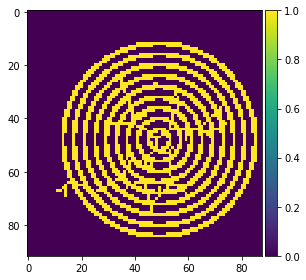

In [84]:
# final = skimage.img_as_ubyte(final)
inverted_cell_image = copy.deepcopy(final)
concentric_coordinates, concentric_intensities = sholl(inverted_cell_image, soma_on_skeleton)
for radius, coordinates in concentric_coordinates.items():
    for coord in coordinates:
        cell_image_with_circles = inverted_cell_image
        cell_image_with_circles[coord[0],coord[1]]=1.5
io.imshow(cell_image_with_circles)
io.show()

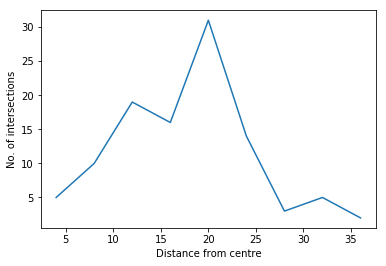

In [74]:
# binary = final > threshold_otsu(final)
concentric_coordinates, concentric_intensities = sholl(final, soma_on_skeleton)
    
xs = []
ys = []
for rad, val in concentric_intensities.items():
    avg = sum(val)
    xs.append(rad)
    ys.append(avg)

order = np.argsort(xs)
x = np.array(xs)[order]
y = np.array(ys)[order]

plt.plot(x, y)
plt.xlabel("Distance from centre")
plt.ylabel("No. of intersections") 
plt.show()

In [72]:
# def plot_folder_avg():
#     avg_intensities = defaultdict(list)
#     for file in os.listdir('.'):
#         cell_image = io.imread(file)
#         gray_cell_image = rgb2gray(cell_image)
#         inverted_cell_image = skimage.util.invert(gray_cell_image)
#         concentric_coordinates, concentric_intensities = sholl(inverted_cell_image, soma)

#         for radius, value in concentric_intensities.items():
#             avg_intensities[radius].append(value)
#     x = []
#     y = []

#     for rad, val in avg_intensities.items():
#         all_intensity_vals = [i[0] for i in val]
#         avg = sum(all_intensity_vals)/ len(val)
#         x.append(rad)
#         y.append(avg)
        
#     return x, y

# os.chdir("/home/user/Desktop/small")
# x, q = plot_folder_avg()

# os.chdir("/home/user/Desktop/large")
# x, z = plot_folder_avg()

# plt.plot(x, q)
# plt.plot(x, z)
# plt.legend(['y = small', 'y = large'], loc='upper right')
# plt.xlabel("Distance from centre")
# plt.ylabel("Intensity")
# plt.show()

## PCA

## Confocal

In [ ]:
# os.chdir("/home/user/Desktop")

In [ ]:
# confocal_section = io.imread("confocal images/SingleGreenchannel.tif")                                   
# confocal_gray_section = rgb2gray(confocal_section) 

In [ ]:
# binary_global = confocal_gray_section > threshold_triangle(confocal_gray_section)
# data = invert(binary_global)

# # display results
# fig, ax = plt.subplots(figsize=(9,5))
# ax.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
# ax.set_title('original')
# ax.set_axis_off()
# fig.tight_layout()
# plt.show()

In [ ]:
# bw = closing(binary_global, square(1))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# image_label_overlay = label2rgb(label_image, image=data)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)

# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 400:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

In [ ]:
# from skimage import morphology

In [ ]:
# boxed_astrocyte = label_image[minr:maxr, minc:maxc]
# final = morphology.remove_small_objects(boxed_astrocyte, 50)
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(final)
# ax.set_axis_off()
# plt.show()

In [ ]:
# import mahotas

# # nuclear = mahotas.imread(nuclear_path)
# nuclear = mahotas.gaussian_filter(binary_global, 3.)
# threshed  = (nuclear > nuclear.mean())
# distances = mahotas.stretch(mahotas.distance(threshed))
# Bc = np.ones((9,9))

# maxima = mahotas.morph.regmax(distances, Bc=Bc)
# spots,n_spots = mahotas.label(maxima, Bc=Bc)
# surface = (distances.max() - distances)
# areas = mahotas.cwatershed(surface, spots)
# areas *= threshed



# import random
# from matplotlib import colors as c
# colors = list(map(plt.cm.jet,range(0, 256, 4)))
# random.shuffle(colors)
# colors[0] = (0.,0.,0.,1.)
# rmap = c.ListedColormap(colors)
# plt.imshow(areas, cmap=rmap)
# plt.show()